In [2]:
import pandas as pd
import numpy as np
from pykrx import stock

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# NAVER 주식 가져오기
df = stock.get_market_ohlcv_by_date('20180101', "20211231", "035420")
df.head()

,시가,고가,저가,종가,거래량
날짜,,,,,
2018-01-02,174447,177251,174247,177251,93587
2018-01-03,175448,177051,173045,174447,84790
2018-01-04,176048,179653,174847,178853,130112
2018-01-05,178852,183858,176249,181857,136811
2018-01-08,183258,190869,181856,190269,196338


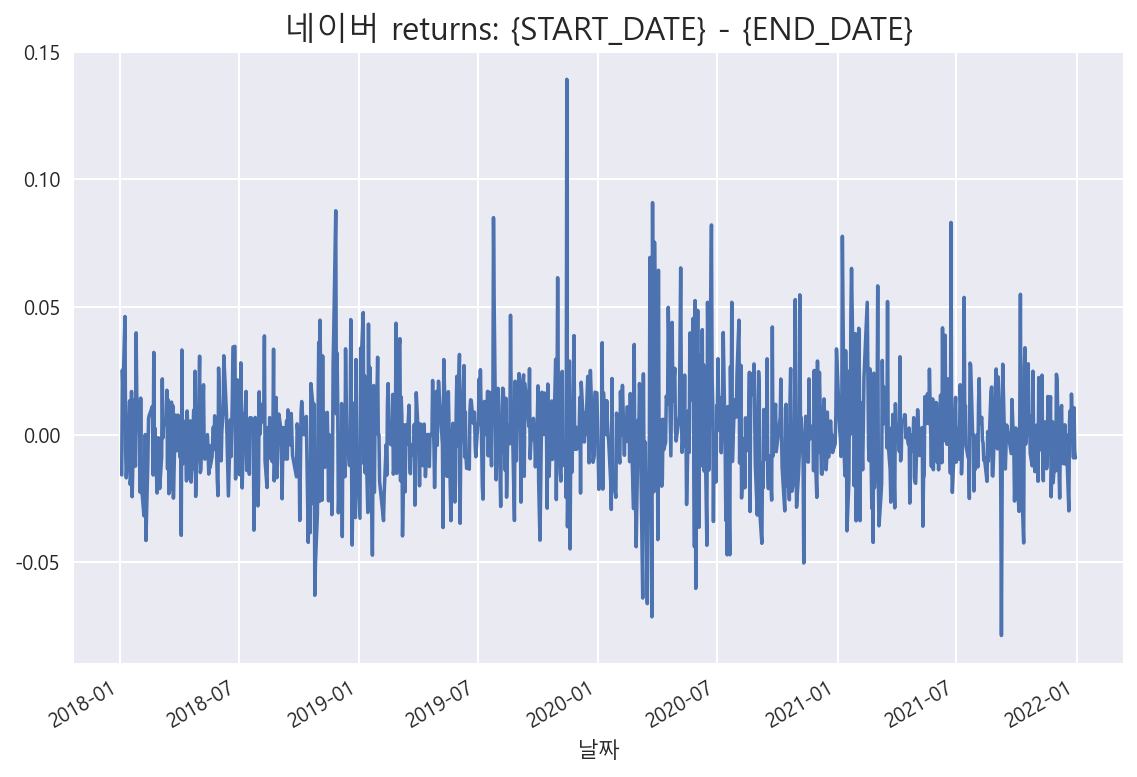

Average return: 0.10%


In [12]:
adj_close = df['종가']
returns = adj_close.pct_change().dropna()

ax = returns.plot()
ax.set_title('네이버 returns: {START_DATE} - {END_DATE}', 
             fontsize=16)

plt.tight_layout()
# plt.savefig('images/ch6_im1.png')
plt.show()

print(f'Average return: {100 * returns.mean():.2f}%')

In [13]:
# 데이터를 훈련과 테스트 집합으로 분할
train = returns['2018-01-01':'2020-12-31']
test = returns['2021-01-01':'2021-12-31']

In [16]:
# 시뮬레이션 매개 변수를 설정한다.
T = len(test)
print(T)
N = len(test)
S_0 = adj_close[train.index[-1]]
print(S_0)
#시뮬레이션 경로 수
N_SIM = 100
# 평균 , 표준편차
mu = train.mean()
sigma = train.std()

248
292500


In [17]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)
    
    dt = T/N
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps 
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

In [18]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

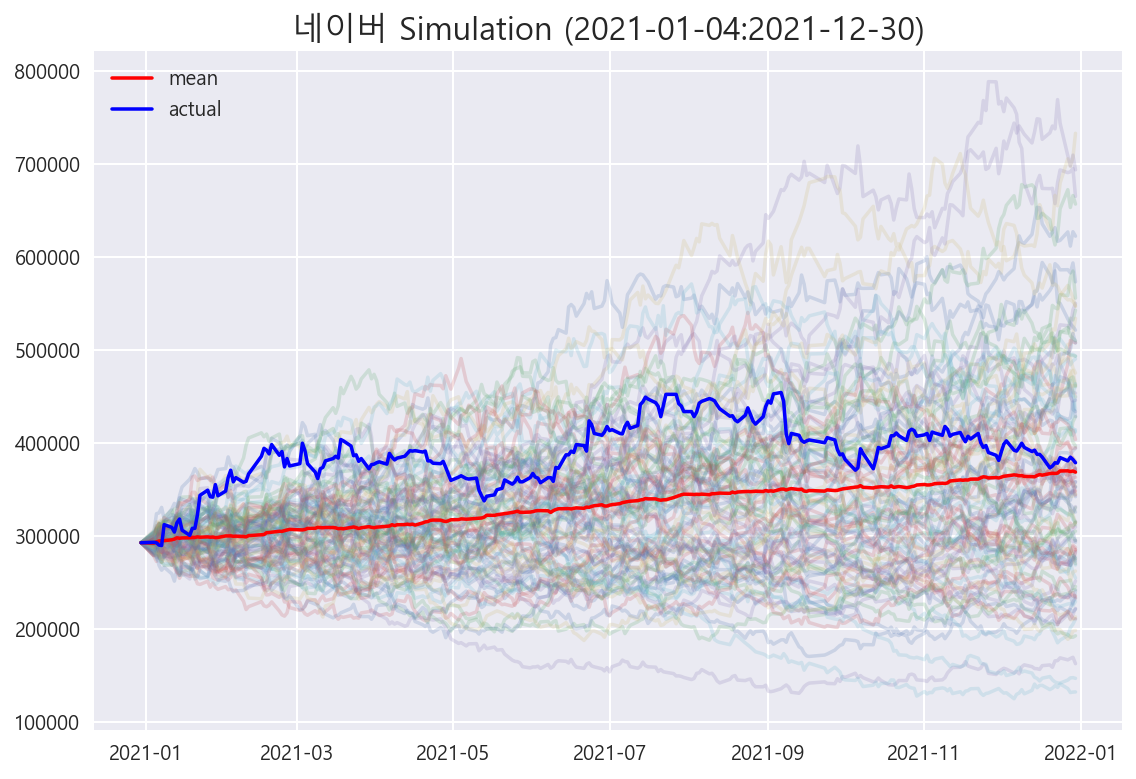

In [24]:
# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'네이버 Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
# plt.savefig('images/ch6_im2.png')
plt.show()

In [25]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

1.42 ms ± 97 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
# 분산 감소 기법
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, antithetic_var=False):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility
    antithetic_var : bool
        Boolean whether to use antithetic variates approach to reduce variance

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    
    np.random.seed(random_seed)
    
    # time increment
    dt = T/N
    
    # Brownian
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0
    
    return S_t

In [27]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

1.22 ms ± 65.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N, antithetic_var=True)

775 µs ± 24.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [30]:
import numpy as np
from scipy.stats import norm
from chapter_6_utils import simulate_gbm

In [31]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.50
T = 1 # 1 year
N = 252 # 252 days in a year
dt = T / N # time step
N_SIMS = 1000000 # number of simulations 
discount_factor = np.exp(-r * T)

In [32]:
def black_scholes_analytical(S_0, K, T, r, sigma, type='call'):
    '''
    Function used for calculating the price of European options using the analytical form of the Black-Scholes model.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    type : str
        Type of the option. Allowable: ['call', 'put']
    
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model
    '''
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if type == 'call':
        val = (S_0 * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1))
    elif type == 'put':
        val = (K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S_0 * norm.cdf(-d1, 0, 1))
    else:
        raise ValueError('Wrong input for type!')
        
    return val

In [33]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='call')

21.79260421286685

In [35]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                       n_sims=N_SIMS, T=T, N=N)

In [36]:
premium = discount_factor * np.mean(np.maximum(0, gbm_sims[:, -1] - K))
premium

21.756178586245806

In [37]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='put')

16.915546662938254

In [38]:
def european_option_simulation(S_0, K, T, r, sigma, n_sims, type='call', random_seed=42):
    '''
    Function used for calculating the price of European options using Monte Carlo simulations.
    
    Parameters
    ------------
    S_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    n_sims : int
        Number of paths to simulate
    type : str
        Type of the option. Allowable: ['call', 'put']
    random_seed : int
        Random seed for reproducibility
        
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using Monte Carlo simulations
    '''
    np.random.seed(random_seed)
    rv = np.random.normal(0, 1, size=n_sims)
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rv)

    if type == 'call':
        payoff = np.maximum(0, S_T - K)
    elif type == 'put':
        payoff = np.maximum(0, K - S_T)
    else: 
        raise ValueError('Wrong input for type!')
        
    premium = np.mean(payoff) * np.exp(-r * T)
    return premium

In [39]:
european_option_simulation(S_0, K, T, r, sigma, N_SIMS, type='put')

16.948225203893127

In [40]:
import numpy as np
from chapter_6_utils import (simulate_gbm, 
                             black_scholes_analytical, 
                             lsmc_american_option)

In [41]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
T = 1 # 1 year
N = 50 
dt = T / N 
N_SIMS = 10 ** 5 
discount_factor = np.exp(-r * dt)
OPTION_TYPE = 'put'
POLY_DEGREE = 5 

In [42]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, 
                        T=T, N=N)

In [43]:
payoff_matrix = np.maximum(K - gbm_sims, np.zeros_like(gbm_sims))

In [44]:
value_matrix = np.zeros_like(payoff_matrix)
value_matrix[:, -1] = payoff_matrix[:, -1]

In [45]:
for t in range(N - 1, 0 , -1):
    regression = np.polyfit(gbm_sims[:, t], 
                            value_matrix[:, t + 1] * discount_factor, 
                            POLY_DEGREE)
    continuation_value = np.polyval(regression, gbm_sims[:, t])
    value_matrix[:, t] = np.where(
        payoff_matrix[:, t] > continuation_value,
        payoff_matrix[:, t],
        value_matrix[:, t + 1] * discount_factor
    )

In [46]:
option_premium = np.mean(value_matrix[:, 1] * discount_factor)
print(f'The premium on the specified American {OPTION_TYPE} option is {option_premium:.3f}')

The premium on the specified American put option is 4.465


In [47]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, 
                         type='put')

3.84430779159684

In [49]:
european_call_price = black_scholes_analytical(S_0=S_0, K=K, T=T, 
                                               r=r, sigma=sigma)
american_call_price = lsmc_american_option(S_0=S_0, K=K, T=T, N=N, r=r, 
                                           sigma=sigma, n_sims=N_SIMS, 
                                           option_type='call', 
                                           poly_degree=POLY_DEGREE)
print(f"The price of the European call is {european_call_price:.3f}, and the American call's price (using {N_SIMS} simulations) is {american_call_price:.3f}")

The price of the European call is 2.174, and the American call's price (using 100000 simulations) is 2.097


In [50]:
S_0 = 36
r = 0.06
sigma = 0.2
K = 40
OPTION_TYPE = 'put'
POLY_DEGREE = 5 
R_SEED = 42
N_SIMS = 10 ** 5 
N = 50 

In [51]:
# Quant Lib
import QuantLib as ql

In [52]:
calendar = ql.UnitedStates()
day_counter = ql.ActualActual()

In [53]:
valuation_date = ql.Date(1, 1, 2018)
expiry_date =  ql.Date(1, 1, 2019)
ql.Settings.instance().evaluationDate = valuation_date

In [54]:
if OPTION_TYPE == 'call':
    option_type_ql = ql.Option.Call
elif OPTION_TYPE == 'put':
    option_type_ql = ql.Option.Put
        
exercise = ql.AmericanExercise(valuation_date, expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

In [55]:
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

In [56]:
# volatility = ql.BlackConstantVol(valuation_date, calendar, sigma, day_counter)
# risk_free_rate = ql.FlatForward(valuation_date, r, day_counter)
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(0, ql.TARGET(), 
                                 ql.QuoteHandle(sigma), 
                                 day_counter)
risk_free_rate = ql.FlatForward(0, ql.TARGET(), 
                                ql.QuoteHandle(r), 
                                day_counter)

In [57]:
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility),
)

In [59]:
engine = ql.MCAmericanEngine(bs_process, 'PseudoRandom', timeSteps=N, 
                             polynomOrder=POLY_DEGREE, 
                             seedCalibration=R_SEED, 
                             requiredSamples=N_SIMS)

In [60]:
option = ql.VanillaOption(payoff, exercise)
option.setPricingEngine(engine)

In [61]:
option_premium_ql = option.NPV()

In [62]:
print(f'The value of the American {OPTION_TYPE} option is: {option_premium_ql:.3f}')

The value of the American put option is: 4.451


In [63]:
u_0 = u.value() # original value
h = 0.01

u.setValue(u_0 + h)
P_plus_h = option.NPV()

u.setValue(u_0 - h)
P_minus_h = option.NPV()

u.setValue(u_0) # set back to the original value

delta = (P_plus_h - P_minus_h) / (2 * h)

print(f'Delta of the option: {delta:.2f}')

Delta of the option: -0.16


In [64]:
# set random seed for reproducibility
np.random.seed(42)

In [146]:
df_1 = stock.get_market_ohlcv_by_date('20100101', "20201231", "035420")
df_2 = stock.get_market_ohlcv_by_date("20100101", "20201231", '035720') 
START_DATE ='20100101'
END_DATE = "20101231"


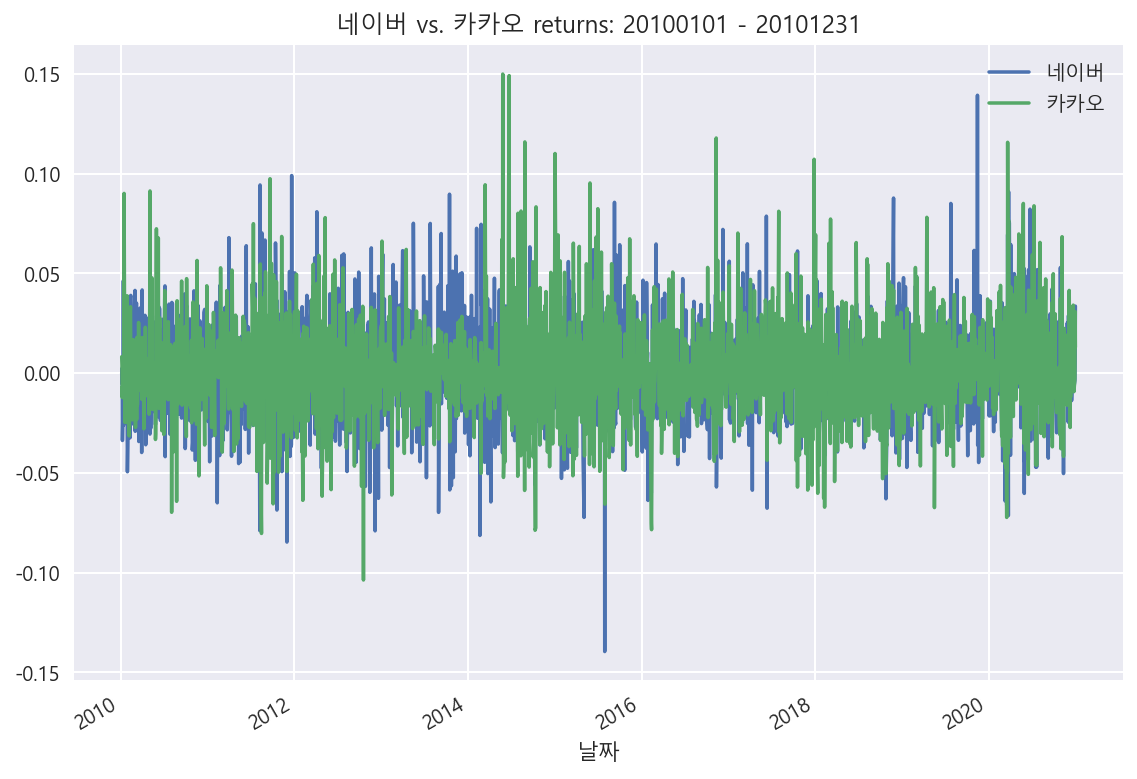

Correlation between returns: 0.30


In [147]:
adj_close_1 = df_1['종가']
adj_close_2 = df_2['종가']
adj_close = pd.concat([adj_close_1,adj_close_2],axis=1)
returns_1 = adj_close_1.pct_change().dropna()
returns_2 = adj_close_2.pct_change().dropna()

returns = pd.concat([returns_1,returns_2],axis=1)
returns.columns = ["네이버","카카오"]
plot_title = f'{" vs. ".join(returns)} returns: {START_DATE} - {END_DATE}'
returns.plot(title=plot_title)

plt.tight_layout()
# plt.savefig('images/ch6_im3.png')
plt.show()

print(f'Correlation between returns: {returns.corr().values[0,1]:.2f}')

In [148]:
cov_mat = returns.cov()
cov_mat

,네이버,카카오
네이버,0.000503,0.000159
카카오,0.000159,0.000542


In [149]:
SHARES = [5, 5]

T = 1
N_SIMS = 10 ** 5

In [150]:
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.02243201, 0.        ],
       [0.00708171, 0.02217017]])

In [151]:
rv = np.random.normal(size=(N_SIMS, 2))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

In [152]:
correlated_rv

array([[ 0.00379487, -0.00149576],
       [ 0.02594543,  0.01262683],
       [ 0.01939496,  0.03728938],
       ...,
       [-0.03899068,  0.00377782],
       [-0.03735832,  0.04107274],
       [-0.0120524 ,  0.00141224]])

In [153]:
r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = adj_close.values[-1, :]
P_0 = np.sum(SHARES * S_0)

In [154]:
S_0

array([292500,  78179])

In [155]:
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + 
                   sigma * np.sqrt(T) * correlated_rv)

In [156]:
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

In [157]:
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}원')

1-day VaR with 99.99% confidence: 2095.98원
1-day VaR with 99.9% confidence: 1483.40원
1-day VaR with 99.0% confidence: 842.93원


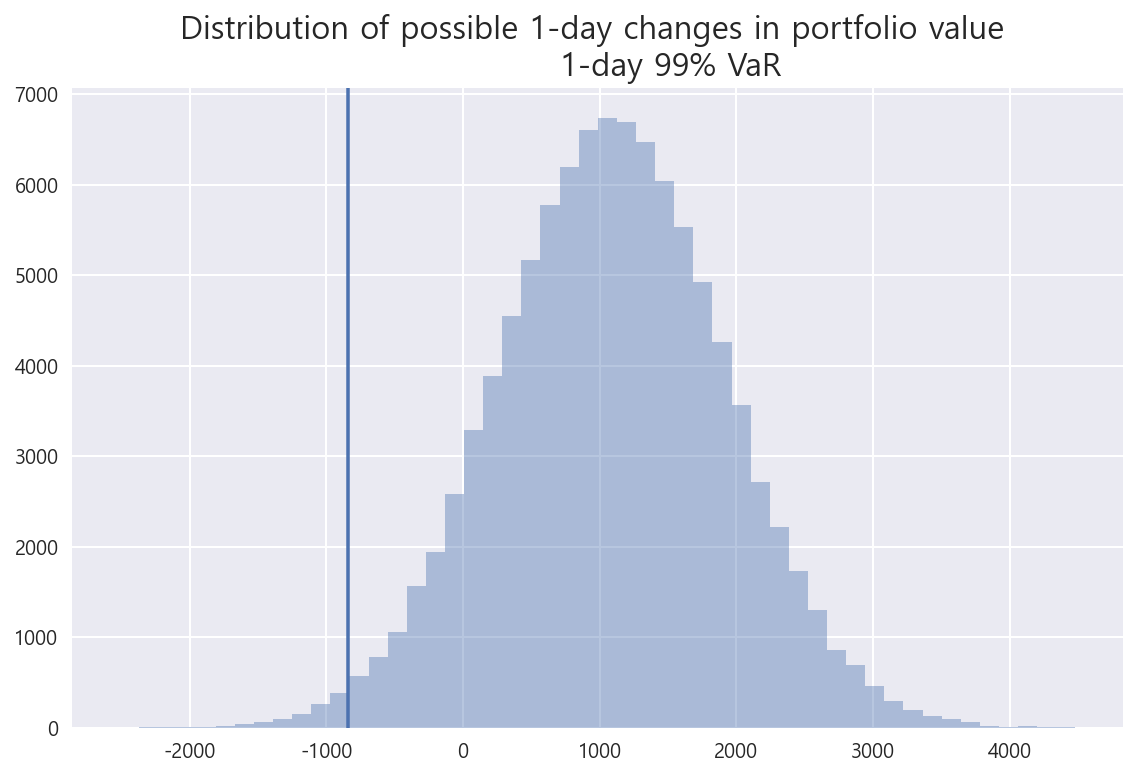

In [158]:
import seaborn as sns
ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value 
             1-day 99% VaR''', fontsize=16)
ax.axvline(var[2], 0, 10000)

plt.tight_layout()
# plt.savefig('images/ch6_im4.png')
plt.show()

In [159]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()

In [160]:
print(f'The 1-day 95% VaR is {-var:.2f}$, and the accompanying Expected Shortfall is {-expected_shortfall:.2f}$.')

The 1-day 95% VaR is 272.63$, and the accompanying Expected Shortfall is 619.38$.


# 의문점 VaR을 과거 시뮬레이션으로 했을 때 주가가 낮아질 때의 기간과 높아질 때의 기간을 분리해서 할 때 VaR의 값차이는 얼마나 되는가